# **-------------------------------TRABALHO CCBA----------------------------------**

- David Carvalho, nº2242131
- Lígia Carteado Mena, nº2242194
- Rui Filipe Parada, nº2211025

#### **ATENÇÃO**

**Dados a alterar ao correr o código:**
- **bucket**: secção "2. Upload do dataset"
- **key**: secção "2. Upload do dataset"
- **ENDPOINT_NAME**: atualizar nome do endpoint nos documentos "streamlit_ccba.py" e "previsao_tempo_real" com base no nome dado na secção "7. Deploy do endpoint"

**Ficheiros:**
- na secção "5. Preprocessing" são criados dois ficheiros plk. Ter a certeza que estes ficheiros são colocados fora de qualquer pasta na aba de ficehiros do Sagemaker, para não interferir nos diretórios tanto no documento "previsao_tempo_real" como no "streamlit_ccba.py"

**Bibliotecas:** 
- a célula de imports pode gerar um erro devido às versões instaladas do pip install -U category_encoders. para o ultrapassar (em caso de erro) deve fazer "shut down kernel" e correr novamente a célula de imports

## **1. IMPORTS**

In [1]:
# =====================================
# 1. IMPORTS DE BIBLIOTECAS
# =====================================

# SageMaker
import sagemaker
from sagemaker.session import Session
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.serializers import CSVSerializer
from sagemaker import image_uris

# AWS
import boto3

# Manipulação de dados
import pandas as pd
import numpy as np
from io import StringIO

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelação
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Avaliação
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Codificadores
!pip install -U category_encoders
import joblib
from category_encoders import TargetEncoder

# Estatística
from scipy.stats import chi2_contingency

# Outros
from IPython.display import display, Markdown
import warnings

# Ignorar warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## **2. UPLOAD DO DATASET**

In [2]:
# =====================================
# 2. LEITURA DO FICHEIRO CSV 
# =====================================

# Localizações no S3
bucket = 'sagemaker-studio-ab58uyhx74k'
key = 'projeto_ccba_data/smartphones.csv'
prefix = 'projeto_ccba_data'
input_data = f"s3://{bucket}/{key}"

s3 = boto3.client('s3')
csv_obj = s3.get_object(Bucket=bucket, Key=key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string))

print(df.head())

# Parâmetros do SageMaker
role = sagemaker.get_execution_role()
s3_output_location = f"s3://{bucket}/ccba_projeto/output/"

                                     Smartphone     Brand           Model  \
0            Realme C55 8/256GB Sunshower Libre    Realme             C55   
1      Samsung Galaxy M23 5G 4/128GB Azul Libre   Samsung      Galaxy M23   
2  Motorola Moto G13 4/128GB Azul Lavanda Libre  Motorola        Moto G13   
3      Xiaomi Redmi Note 11S 6/128GB Gris Libre    Xiaomi  Redmi Note 11S   
4       Nothing Phone (2) 12/512GB Blanco Libre   Nothing       Phone (2)   

    RAM  Storage   Color Free  Final Price  
0   8.0    256.0  Yellow  Yes       231.60  
1   4.0    128.0    Blue  Yes       279.00  
2   4.0    128.0    Blue  Yes       179.01  
3   6.0    128.0    Gray  Yes       279.99  
4  12.0    512.0   White  Yes       799.00  


## **3. ANÁLISE INICIAL**

In [3]:
# =====================================
# 3. ANÁLISE INICIAL
# =====================================

display(Markdown("**-----   Formato do dataset:   -----**"))
print(df.shape)
print("\n")

display(Markdown("**-----   Informações do dataset:   -----**"))
df.info()
print("\n")

display(Markdown("**-----   Estatísticas descritivas:   -----**"))
display(df.describe())
print("\n")

display(Markdown("**-----   Contagem de valores nulos:   -----**"))
print(df.isnull().sum())
print("\n")

display(Markdown("**-----   Contagem de linhas duplicadas:   -----**"))
print(df.duplicated().sum())
print("\n")

display(Markdown("**-----   Tipos de dados por coluna:   -----**"))
print(df.dtypes)
print("\n")

**-----   Formato do dataset:   -----**

(1816, 8)




**-----   Informações do dataset:   -----**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Smartphone   1816 non-null   object 
 1   Brand        1816 non-null   object 
 2   Model        1816 non-null   object 
 3   RAM          1333 non-null   float64
 4   Storage      1791 non-null   float64
 5   Color        1816 non-null   object 
 6   Free         1816 non-null   object 
 7   Final Price  1816 non-null   float64
dtypes: float64(3), object(5)
memory usage: 113.6+ KB




**-----   Estatísticas descritivas:   -----**

,RAM,Storage,Final Price
count,1333.00000,1791.000000,1816.000000
mean,5.96099,162.652150,492.175573
std,2.66807,139.411605,398.606183
min,1.00000,2.000000,60.460000
25%,4.00000,64.000000,200.990000
50%,6.00000,128.000000,349.990000
75%,8.00000,256.000000,652.717500
max,12.00000,1000.000000,2271.280000


**-----   Contagem de valores nulos:   -----**

Smartphone       0
Brand            0
Model            0
RAM            483
Storage         25
Color            0
Free             0
Final Price      0
dtype: int64




**-----   Contagem de linhas duplicadas:   -----**

0




**-----   Tipos de dados por coluna:   -----**

Smartphone      object
Brand           object
Model           object
RAM            float64
Storage        float64
Color           object
Free            object
Final Price    float64
dtype: object




In [4]:
### CATEGORIZAR OS PREÇOS EM INTERVALOS

def categorizar_preco(preco):
    if preco < 200:
        return 'baixo'
    elif preco < 500:
        return 'médio'
    elif preco < 950:
        return 'alto'
    else:
        return 'muito alto'

df["price_range"] = df["Final Price"].apply(categorizar_preco)


Correlação entre variáveis numéricas e a variável alvo (price_range):


,price_range_num
price_range_num,1.000000
RAM,0.707665
Storage,0.603023


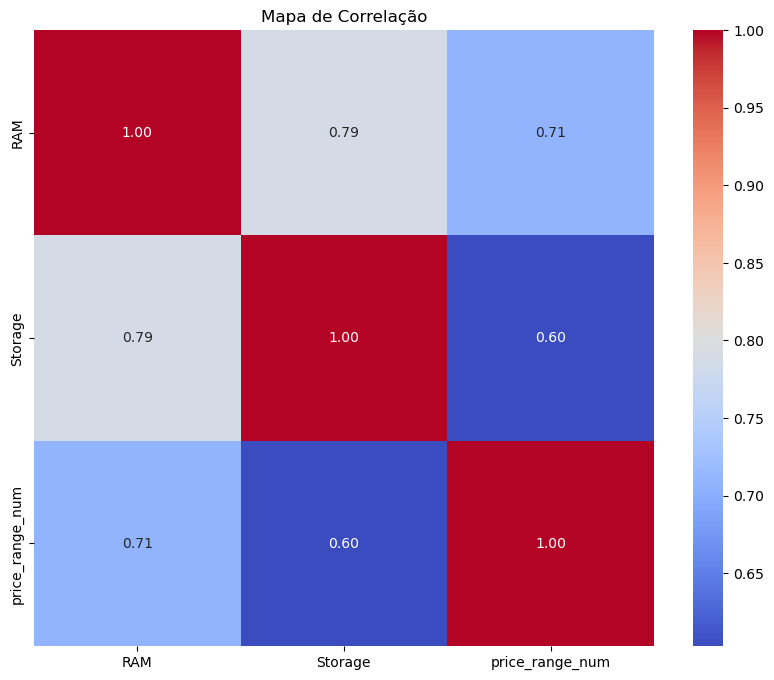

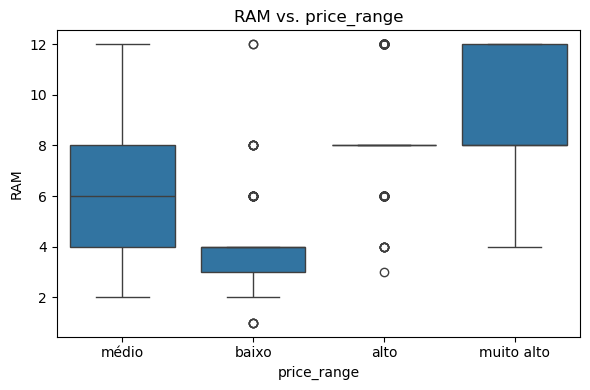

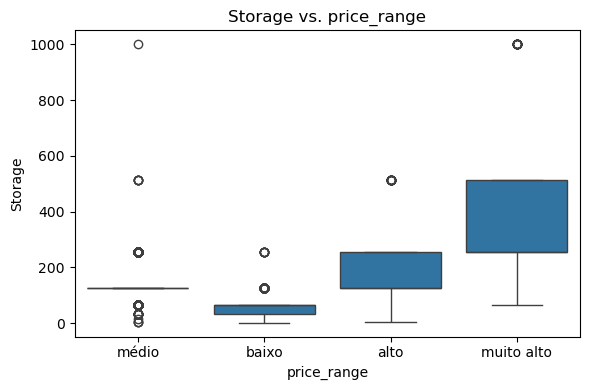




Teste de associação (Qui-quadrado) entre variáveis categóricas e price_range:
Smartphone: p-valor = 0.4860 -> NÃO associado
Brand: p-valor = 0.0000 -> ASSOCIADO
Model: p-valor = 0.0000 -> ASSOCIADO
Color: p-valor = 0.0000 -> ASSOCIADO
Free: p-valor = 0.0025 -> ASSOCIADO


In [5]:
# =====================================
# 3.1. ANÁLISE DA RELAÇÃO ENTRE VARIÁVEIS E O TARGET
# =====================================

categorical_vars = ['Smartphone', 'Brand', 'Model', 'Color', 'Free']
numerical_vars = ['RAM', 'Storage']

# --- Criar coluna numérica temporária para o target ---
price_range_map = {
    'baixo': 0,
    'médio': 1,
    'alto': 2,
    'muito alto': 3
}
df['price_range_num'] = df['price_range'].map(price_range_map)

# --- Relação entre variáveis numéricas e o target ---
print("\nCorrelação entre variáveis numéricas e a variável alvo (price_range):")
correlation_df = df[numerical_vars + ['price_range_num']].corr()
display(correlation_df[['price_range_num']].sort_values(by='price_range_num', ascending=False))

print("\n")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Correlação")
plt.show()

print("\n")

# --- Boxplots para variáveis numéricas vs. target ---
for col in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="price_range", y=col, data=df)
    plt.title(f"{col} vs. price_range")
    plt.tight_layout()
    plt.show()

print("\n")

# --- Teste do Qui-quadrado para variáveis categóricas ---
print("\nTeste de associação (Qui-quadrado) entre variáveis categóricas e price_range:")
for col in categorical_vars:
    table = pd.crosstab(df[col], df['price_range'])
    chi2, p, dof, ex = chi2_contingency(table)
    print(f"{col}: p-valor = {p:.4f} {'-> ASSOCIADO' if p < 0.05 else '-> NÃO associado'}")



df.drop(columns='price_range_num', inplace=True)

In [6]:
### VERIFICAR QUANTIDADE DE OUTLIERS NAS COLUNAS 'FC', 'PX_HEIGHT' E 'RAM' -> com base na visualização dos boxplots

colunas = ['RAM', 'Storage']

for coluna in colunas:
    outliers_total = 0
    print(f"\nOutliers na coluna '{coluna}':")

    for categoria in df['price_range'].unique():
        grupo = df[df['price_range'] == categoria]
        Q1 = grupo[coluna].quantile(0.25)
        Q3 = grupo[coluna].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 3 * IQR
        lim_sup = Q3 + 3 * IQR

        outliers = grupo[(grupo[coluna] < lim_inf) | (grupo[coluna] > lim_sup)]
        print(f"  Categoria {categoria}: {len(outliers)} outliers")
        outliers_total += len(outliers)

    print(f"  Total de outliers na coluna '{coluna}': {outliers_total}")


Outliers na coluna 'RAM':
  Categoria médio: 0 outliers
  Categoria baixo: 9 outliers
  Categoria alto: 104 outliers
  Categoria muito alto: 0 outliers
  Total de outliers na coluna 'RAM': 113

Outliers na coluna 'Storage':
  Categoria médio: 306 outliers
  Categoria baixo: 7 outliers
  Categoria alto: 0 outliers
  Categoria muito alto: 0 outliers
  Total de outliers na coluna 'Storage': 313


In [7]:
### VERIFICAR SE EXISTEM LINHAS DUPLICADAS

duplicados = df.duplicated()
print(f"Total de linhas duplicadas: {duplicados.sum()}")     ### o valor vai ser 0 devido à coluna 'Smartphone'. sem essa coluna o número de duplicados é 881

Total de linhas duplicadas: 0


In [8]:
### VERIFICAR SE A COLUNA 'Color' TEM NULOS

df['Color'].isnull().sum()

0

## **4. TRATAMENTO DOS DADOS**

In [9]:
# =====================================
# 4. TRATAMENTO DOS DADOS
# =====================================

### DROP DE COLUNAS IRRELEVANTES

df = df.drop(columns=["Final Price"])
df = df.drop(columns=["Smartphone"])
df = df.drop(columns=["Free"])





### TRATAMENTO DE NAN

apple_ram_map = {
    'iPhone 6s': 2,
    'iPhone 7': 2,
    'iPhone 8': 2,
    'iPhone SE': 3,
    'iPhone X': 3,
    'iPhone XR': 3,
    'iPhone XS': 4,
    'iPhone 11': 4,
    '11 Pro': 4,
    'iPhone 12': 4,
    'iPhone 13': 4,
    'iPhone 14': 6
}


for model, ram in apple_ram_map.items():
    mask = (df['Brand'] == 'Apple') & (df['Model'] == model) & (df['RAM'].isnull())
    df.loc[mask, 'RAM'] = ram

non_apple_median = df.loc[(df['Brand'] != 'Apple'), 'RAM'].median()
df.loc[(df['Brand'] != 'Apple') & (df['RAM'].isnull()), 'RAM'] = non_apple_median
print(f"Valores nulos restantes em RAM: {df['RAM'].isnull().sum()}")


df = df.dropna(subset=['Storage']).reset_index(drop=True)
print(f"Valores nulos restantes em Storage: {df['Storage'].isnull().sum()}")





### DROP DE OUTLIERS

colunas_outliers = ['RAM', 'Storage']
outlier_indices = set()

for coluna in colunas_outliers:
    for categoria in df['price_range'].unique():
        grupo = df[df['price_range'] == categoria]
        Q1 = grupo[coluna].quantile(0.25)
        Q3 = grupo[coluna].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 3 * IQR
        lim_sup = Q3 + 3 * IQR

        outliers = grupo[(grupo[coluna] < lim_inf) | (grupo[coluna] > lim_sup)]
        outlier_indices.update(outliers.index)

df.drop(index=outlier_indices, inplace=True)


Valores nulos restantes em RAM: 0
Valores nulos restantes em Storage: 0


In [10]:
### VERIFICAR SE EXISTEM LINHAS DUPLICADAS -> agora sem a coluna 'Smartphone'

duplicados = df.duplicated()
print(f"Total de linhas duplicadas: {duplicados.sum()}")

Total de linhas duplicadas: 333


In [11]:
### REMOVER LINHAS DUPLICADAS

df = df.drop_duplicates().reset_index(drop=True)

In [12]:
### VERIFICAR O FORMATO DO DATASET APÓS O TRATAMENTO DE DADOS

print("\nFormato do dataset após o tratamento de dados:")
df.shape


Formato do dataset após o tratamento de dados:


(1145, 6)

## **5. PREPROCESSING**

In [13]:
# Parâmetros
# 'bucket'  e 'prefix' definidos no ponto 2. Upload do dataset 
s3_output_location = f"s3://{bucket}/{prefix}/output/"

# 1. Mover a coluna target para a primeira posição
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]  # move 'price_range' para o início
df = df[cols]

# 2. Dividir em train, test e validate com stratify
train, test_and_validate = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['price_range']
)

test, validate = train_test_split(
    test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['price_range']
)

# 3. Codificar o target (LabelEncoder) para cada conjunto
le_target = LabelEncoder()

y_train = le_target.fit_transform(train['price_range'])
y_test = le_target.transform(test['price_range'])
y_validate = le_target.transform(validate['price_range'])

# 4. Separar features e aplicar encoding com ColumnTransformer
categorical_features = ['Brand', 'Model', 'Color']
numerical_features = ['RAM', 'Storage']

# Define o pipeline de transformação
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Ajustar apenas nos dados de treino
X_train = train.drop(columns='price_range')
X_test = test.drop(columns='price_range')
X_validate = validate.drop(columns='price_range')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_validate_processed = preprocessor.transform(X_validate)

# Obter os nomes das colunas codificadas
encoded_feature_names = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(categorical_features)
    .tolist() + numerical_features
)

# Converter para DataFrames
X_train = pd.DataFrame(X_train_processed, columns=encoded_feature_names)
X_test = pd.DataFrame(X_test_processed, columns=encoded_feature_names)
X_validate = pd.DataFrame(X_validate_processed, columns=encoded_feature_names)

# Salvar encoder (ColumnTransformer) e LabelEncoder
joblib.dump(preprocessor, 'encoder_ccba.pkl')
joblib.dump(le_target, 'label_encoder_ccba.pkl')

# Upload do encoder para o S3
s3 = boto3.client('s3')
s3.upload_file('encoder_ccba.pkl', bucket, prefix + '/encoder/encoder_ccba.pkl')
s3.upload_file('label_encoder_ccba.pkl', bucket, prefix + '/encoder/label_encoder_ccba.pkl')

# Concatenar y com X para upload
train_to_upload = pd.concat([pd.Series(y_train, name='price_range'), X_train], axis=1)
test_to_upload = pd.concat([pd.Series(y_test, name='price_range'), X_test], axis=1)
validate_to_upload = pd.concat([pd.Series(y_validate, name='price_range'), X_validate], axis=1)

# Função de upload para S3
def upload_s3_csv(df, bucket, prefix, filename):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, f"{prefix}/{filename}").put(Body=csv_buffer.getvalue())

# Upload dos dados para S3
upload_s3_csv(train_to_upload, bucket, prefix + '/train', 'train.csv')
upload_s3_csv(test_to_upload, bucket, prefix + '/test', 'test.csv')
upload_s3_csv(validate_to_upload, bucket, prefix + '/validate', 'validate.csv')

print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)
print('Validate shape:', X_validate.shape, y_validate.shape)
print(f'Encoder salvo no S3: s3://{bucket}/{prefix}/encoder/encoder_ccba.pkl')
print(f'Label Encoder salvo no S3: s3://{bucket}/{prefix}/encoder/label_encoder_ccba.pkl')

Train shape: (916, 370) (916,)
Test shape: (114, 370) (114,)
Validate shape: (115, 370) (115,)
Encoder salvo no S3: s3://sagemaker-studio-ab58uyhx74k/projeto_ccba_data/encoder/encoder_ccba.pkl
Label Encoder salvo no S3: s3://sagemaker-studio-ab58uyhx74k/projeto_ccba_data/encoder/label_encoder_ccba.pkl


#### **Guardar o scaler para reutilizar mais tarde**

**Porquê?**
Porque se no futuro quisermos prever com dados novos, precisamos usar a mesma média e desvio padrão que usamos no treino. Senão, os valores transformados vão ficar incorretos.

## **6. MODELING**

In [14]:
role = sagemaker.get_execution_role()

train_s3_path = f"s3://{bucket}/{prefix}/train/"
validate_s3_path = f"s3://{bucket}/{prefix}/validate/"

# Hyperparâmetros
hyperparameters = {
    "objective": "multi:softmax",
    "num_class": "4",
    "eval_metric": "mlogloss",
    "num_round": "100",
    "max_depth": "3",
    "eta": "0.1",
    "subsample": "0.8",
    "min_child_weight": "5",
    "early_stopping_rounds": "10"
}

# Obter URI da imagem do XGBoost incorporado
xgboost_container = image_uris.retrieve(
    framework='xgboost',
    region=sagemaker.Session().boto_region_name,
    version='1.0-1'
)

# Criar estimator incorporado (sem script)
xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    hyperparameters=hyperparameters
)

# Dados
train_input = sagemaker.inputs.TrainingInput(train_s3_path, content_type='csv')
validate_input = sagemaker.inputs.TrainingInput(validate_s3_path, content_type='csv')
data_channels = {'train': train_input, 'validation': validate_input}

# Treino (fit do modelo)
xgb_estimator.fit(inputs=data_channels)

[06/12/25 15:35:27] INFO     Defaulting to only available Python version: py3                     ]8;id=735954;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=771796;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=21863;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=751342;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#534\534]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=562609;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=261190;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=755161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=623454;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-06-12-15-35-27-078                                             

2025-06-12 15:35:31 Starting - Starting the training job...
2025-06-12 15:35:45 Starting - Preparing the instances for training...
2025-06-12 15:36:31 Downloading - Downloading the training image......
2025-06-12 15:37:28 Training - Training image download completed. Training in progress.
2025-06-12 15:37:28 Uploading - Uploading generated training model[2025-06-12 15:37:22.396 ip-10-0-209-36.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value mlogloss to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','


## **7. DEPLOY DO ENDPOINT**

[06/12/25 15:38:19] INFO     Creating model with name: sagemaker-xgboost-2025-06-12-15-38-19-254    ]8;id=943077;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=256119;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=399762;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=854145;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             sagemaker-xgboost-2025-06-12-15-38-19-254                                             

[06/12/25 15:38:20] INFO     Creating endpoint with name sagemaker-xgboost-2025-06-12-15-38-19-254  ]8;id=470043;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=736495;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

------!

Classification Report (Treino):
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       240
           1       0.93      0.81      0.86       289
           2       0.81      0.52      0.63       112
           3       0.66      0.93      0.77       275

    accuracy                           0.76       916
   macro avg       0.78      0.72      0.74       916
weighted avg       0.78      0.76      0.76       916

Classification Report (Validação):
              precision    recall  f1-score   support

           0       0.76      0.53      0.63        30
           1       0.93      0.75      0.83        36
           2       0.67      0.57      0.62        14
           3       0.64      0.97      0.77        35

    accuracy                           0.74       115
   macro avg       0.75      0.71      0.71       115
weighted avg       0.77      0.74      0.73       115



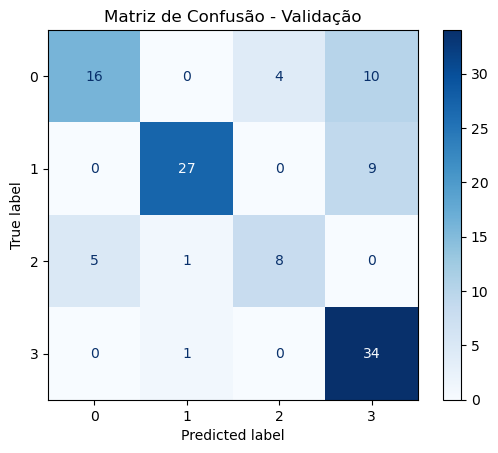

In [15]:
sagemaker_session = Session()

# Deploy direto do estimator (modelo incorporado XGBoost)
xgb_predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer()
)

# 1. Preparar dados de validação para enviar ao endpoint
# Converter X_validate para CSV (sem header nem índice)
csv_data = X_validate.to_csv(index=False, header=False)

# 2. Enviar os dados para o endpoint e receber as previsões
response = xgb_predictor.predict(csv_data)

# 3. Converter a resposta para array numpy
y_pred = np.fromstring(response, sep=',')

# 4. Mostrar relatório de classificação
# === NOVO BLOCO: Classification Report - Treino ===
# 4b. Preparar dados de treino 
csv_data_train = X_train.to_csv(index=False, header=False)

# 4c. Obter previsões para o conjunto de treino
response_train = xgb_predictor.predict(csv_data_train)

# 4d. Converter resposta para array numpy
y_pred_train = np.fromstring(response_train, sep=',')

print("\n")

# 4e. Mostrar relatório de classificação - treino
print("Classification Report (Treino):")
print(classification_report(y_train, y_pred_train))
# === FIM DO BLOCO ===

print("Classification Report (Validação):")
print(classification_report(y_validate, y_pred))

# 5. Matriz de confusão da validação 
cm = confusion_matrix(y_validate, y_pred, labels=np.unique(y_validate))

# 6. Visualizar matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_validate))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Validação")
plt.show()

## **8. DELETE**

In [19]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)
print("Endpoint apagado.")

[06/11/25 22:16:48] INFO     Deleting endpoint configuration with name:                             ]8;id=346991;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=263204;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             sagemaker-xgboost-2025-06-11-21-54-14-320                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-06-11-21-54-14-320 ]8;id=409160;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=846762;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\

Endpoint apagado.
